In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import nltk
from nltk.corpus import stopwords
import pymorphy3
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Инициализация лемматизатора
morph = pymorphy3.MorphAnalyzer()

# Функции для предобработки
def read_file(filename):
    """Чтение файла с обработкой разных кодировок"""
    encodings = ['utf-8', 'cp1251', 'koi8-r', 'latin-1']
    for enc in encodings:
        try:
            with open(filename, 'r', encoding=enc) as f:
                return f.read()
        except UnicodeDecodeError:
            continue
    raise Exception(f"Не удалось прочитать файл {filename}")

def preprocess_text(text, lemmatize=False, remove_stops=False, filter_markers=True):
    """Базовая предобработка текста"""
    # Приводим к нижнему регистру
    text = text.lower()
    
    if filter_markers:
        words = text.split()
        filtered_words = []
        
        # Список служебных меток для удаления
        markers = ['рц', 'п', 'каб1', 'пбл4', 'мд1', 'рц1', 'пбл1', 'каб', 'пбл']
        
        for word in words:
            # Пропускаем если есть цифры
            if any(c.isdigit() for c in word):
                continue
            
            # Пропускаем если это служебная метка
            if word in markers:
                continue
            
            # Пропускаем если очень короткое слово (1-2 буквы) и это не местоимение
            if len(word) <= 2 and word not in ['я', 'ты', 'он', 'она', 'оно', 'мы', 'вы', 'они', 'мне', 'меня']:
                continue
                
            filtered_words.append(word)
        
        text = ' '.join(filtered_words)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    
    if lemmatize:
        words = text.split()
        lemmatized = []
        for word in words:
            try:
                lemmatized.append(morph.parse(word)[0].normal_form)
            except:
                lemmatized.append(word)
        text = ' '.join(lemmatized)
    
    return text

def split_into_chunks(text, chunk_size=200, overlap=20):
    """Разбиение текста на чанки заданного размера с перекрытием"""
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.split()) >= 80:  # Минимальный размер чанка
            chunks.append(chunk)
    
    return chunks

# Чтение файлов
print("Чтение файлов...")
text1 = read_file('Secretar_NLP.txt')
text2 = read_file('dead_NLP.txt')

print(f"Размер текста Secretar_NLP: {len(text1)} символов, {len(text1.split())} слов")
print(f"Размер текста dead_NLP: {len(text2)} символов, {len(text2.split())} слов")


# Предобработка текстов с фильтрацией
print("\nПредобработка текстов...")
text1_processed = preprocess_text(text1, filter_markers=True)
text2_processed = preprocess_text(text2, filter_markers=True)

# Разбиение на чанки
print("Разбиение на чанки...")
chunks1 = split_into_chunks(text1_processed, chunk_size=200, overlap=20)
chunks2 = split_into_chunks(text2_processed, chunk_size=200, overlap=20)

print(f"Количество чанков Secretar_NLP: {len(chunks1)}")
print(f"Количество чанков dead_NLP: {len(chunks2)}")

# Создание датасета
X = chunks1 + chunks2
y = [0] * len(chunks1) + [1] * len(chunks2)

print(f"\nОбщий размер датасета: {len(X)} чанков")
print(f"Распределение классов: 0 (Secretar) - {len(chunks1)}, 1 (dead) - {len(chunks2)}")

# Функция для обучения и оценки модели
def train_and_evaluate(X, y, vectorizer_params, description):
    """Обучение и оценка модели с заданными параметрами векторизатора"""
    print(f"\n{'='*60}")
    print(f"Эксперимент: {description}")
    print('='*60)
    
    # Векторизация
    vectorizer = CountVectorizer(**vectorizer_params)
    X_vec = vectorizer.fit_transform(X)
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_vec, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Обучение модели
    nb = MultinomialNB(alpha=1.0)
    nb.fit(X_train, y_train)
    
    # Предсказания
    y_pred = nb.predict(X_test)
    
    # Метрики
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Secretar', 'dead'])
    f1 = f1_score(y_test, y_pred)
    
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\nClassification Report:")
    print(report)
    print(f"F1-score: {f1:.4f}")
    
    # Топ важных токенов
    feature_names = vectorizer.get_feature_names_out()
    
    # Для класса 0 (Secretar)
    log_prob_0 = nb.feature_log_prob_[0]
    # Для класса 1 (dead)
    log_prob_1 = nb.feature_log_prob_[1]
    
    # Δ(w) = P(w|класс1) - P(w|класс0)
    delta = np.exp(log_prob_1) - np.exp(log_prob_0)
    
    # Топ-20 токенов для каждого класса
    top_20_class0_idx = np.argsort(-np.exp(log_prob_0))[:20]
    top_20_class1_idx = np.argsort(-np.exp(log_prob_1))[:20]
    
    # Токены с наибольшей разницей (характерные для dead)
    top_delta_idx = np.argsort(-delta)[:20]
    
    print(f"\nТоп-20 токенов, характерных для Secretar:")
    for idx in top_20_class0_idx:
        print(f"  {feature_names[idx]}: {np.exp(log_prob_0[idx]):.6f}")
    
    print(f"\nТоп-20 токенов, характерных для dead:")
    for idx in top_20_class1_idx:
        print(f"  {feature_names[idx]}: {np.exp(log_prob_1[idx]):.6f}")
    
    print(f"\nТоп-20 токенов на основе Δ(w) (характерные для dead):")
    for idx in top_delta_idx[:20]:
        print(f"  {feature_names[idx]}: {delta[idx]:.6f}")
    
    return nb, vectorizer, f1, delta, feature_names

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qweds\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qweds\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Чтение файлов...
Размер текста Secretar_NLP: 494748 символов, 77388 слов
Размер текста dead_NLP: 2322504 символов, 358336 слов

Предобработка текстов...
Разбиение на чанки...
Количество чанков Secretar_NLP: 332
Количество чанков dead_NLP: 1539

Общий размер датасета: 1871 чанков
Распределение классов: 0 (Secretar) - 332, 1 (dead) - 1539


In [2]:
params_basic = {
    'analyzer': 'word',
    'token_pattern': r'(?u)\b\w+\b',
    'max_features': 10000,
    'min_df': 2,
    'max_df': 0.95
}

nb_basic, vec_basic, f1_basic, delta_basic, features_basic = train_and_evaluate(
    X, y, params_basic, "Базовый (только униграммы)"
)


print("\nПодготовка данных с лемматизацией...")
X_lemmatized = []
for chunk in X:
    X_lemmatized.append(preprocess_text(chunk, lemmatize=True, filter_markers=False))

params_lemmatized = params_basic.copy()
nb_lemma, vec_lemma, f1_lemma, delta_lemma, features_lemma = train_and_evaluate(
    X_lemmatized, y, params_lemmatized, "С лемматизацией"
)


print("\nПодготовка данных с удалением стоп-слов...")
stop_words = set(stopwords.words('russian'))
params_stop = params_basic.copy()
params_stop['stop_words'] = list(stop_words)

nb_stop, vec_stop, f1_stop, delta_stop, features_stop = train_and_evaluate(
    X, y, params_stop, "С удалением стоп-слов"
)


print("\nЭксперимент с биграммами...")
params_ngram = params_basic.copy()
params_ngram['ngram_range'] = (1, 2)
params_ngram['max_features'] = 15000

nb_ngram, vec_ngram, f1_ngram, delta_ngram, features_ngram = train_and_evaluate(
    X, y, params_ngram, "С биграммами (1-2)"
)


Эксперимент: Базовый (только униграммы)

Confusion Matrix:
[[100   0]
 [  0 462]]

Classification Report:
              precision    recall  f1-score   support

    Secretar       1.00      1.00      1.00       100
        dead       1.00      1.00      1.00       462

    accuracy                           1.00       562
   macro avg       1.00      1.00      1.00       562
weighted avg       1.00      1.00      1.00       562

F1-score: 1.0000

Топ-20 токенов, характерных для Secretar:
  я: 0.030128
  меня: 0.013058
  ты: 0.009826
  как: 0.009566
  это: 0.009197
  мне: 0.008459
  то: 0.008351
  самаэль: 0.007678
  он: 0.007613
  все: 0.007093
  так: 0.006442
  его: 0.005488
  только: 0.004685
  вот: 0.004577
  было: 0.004230
  падший: 0.004230
  еще: 0.004165
  нет: 0.003622
  тебя: 0.003622
  уже: 0.003622

Топ-20 токенов, характерных для dead:
  как: 0.017276
  он: 0.015736
  его: 0.008564
  было: 0.008537
  так: 0.008441
  это: 0.007974
  то: 0.007672
  я: 0.007040
  всё: 0.00618

In [3]:
results = pd.DataFrame({
    'Эксперимент': ['Базовый', 'С лемматизацией', 'С удалением стоп-слов', 'С биграммами'],
    'F1-score': [f1_basic, f1_lemma, f1_stop, f1_ngram]
})

print("\nСравнение F1-score:")
print(results)


Сравнение F1-score:
             Эксперимент  F1-score
0                Базовый  1.000000
1        С лемматизацией  1.000000
2  С удалением стоп-слов  1.000000
3           С биграммами  0.998917


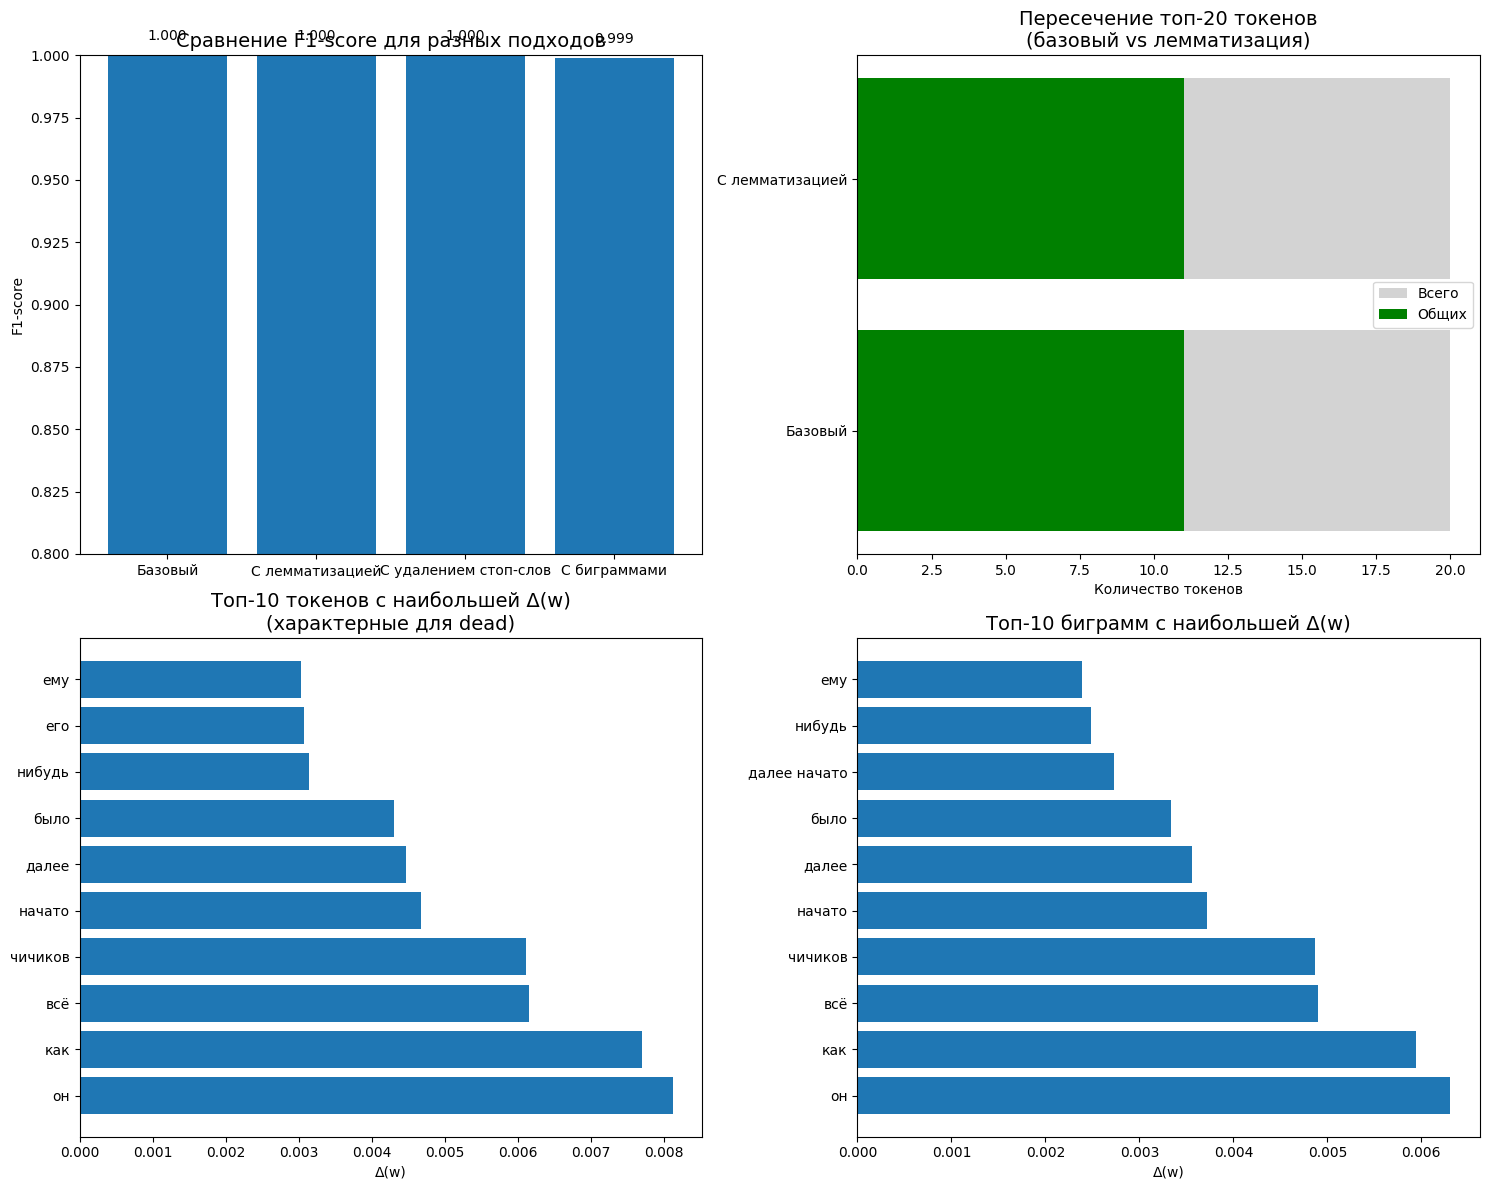


АНАЛИЗ ВАЖНЫХ ТОКЕНОВ

Базовый эксперимент - топ-10 токенов для dead:
  он
  как
  всё
  чичиков
  начато
  далее
  было
  нибудь
  его
  ему

С лемматизацией - топ-10 токенов для dead:
  он
  быть
  как
  чичиков
  который
  какой
  сказать
  начато
  вы
  весь

С удалением стоп-слов - топ-10 токенов для dead:
  всё
  чичиков
  начато
  далее
  сказал
  вместо
  дело
  совершенно
  которые
  однако

С биграммами - топ-10 токенов для dead:
  он
  как
  всё
  чичиков
  начато
  далее
  было
  далее начато
  нибудь
  ему

ЭКСПЕРИМЕНТ С DOMAIN SHIFT
Имитация domain shift (постепенное изменение распределения)...


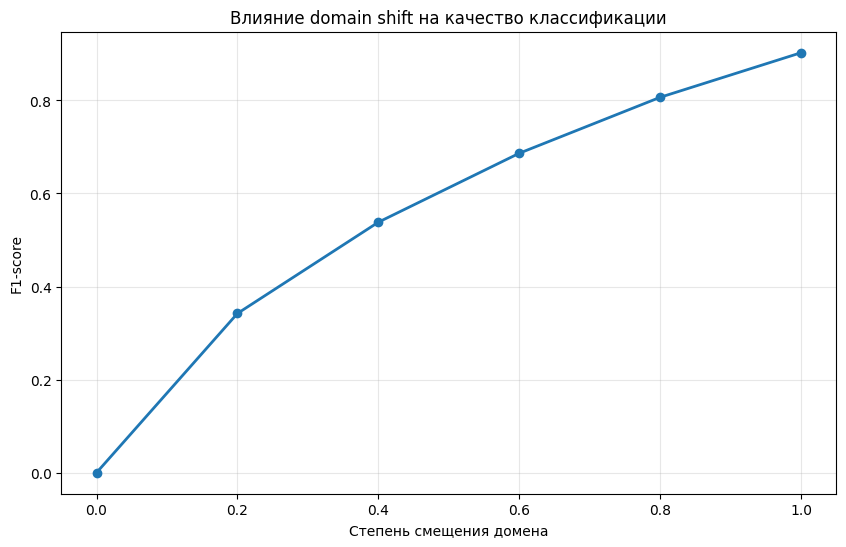

In [4]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Сравнение F1-score
ax = axes[0, 0]
bars = ax.bar(results['Эксперимент'], results['F1-score'])
ax.set_title('Сравнение F1-score для разных подходов', fontsize=14)
ax.set_ylabel('F1-score')
ax.set_ylim(0.8, 1.0)
for bar, val in zip(bars, results['F1-score']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{val:.3f}', ha='center', va='bottom')

# График 2: Сравнение топ-токенов для базового и с лемматизацией
ax = axes[0, 1]
top_20_basic = features_basic[np.argsort(-delta_basic)[:20]]
top_20_lemma = features_lemma[np.argsort(-delta_lemma)[:20]]
common = set(top_20_basic) & set(top_20_lemma)
ax.barh(['Базовый', 'С лемматизацией'], 
        [20, 20], color='lightgray', label='Всего')
ax.barh(['Базовый', 'С лемматизацией'], 
        [len(common), len(common)], color='green', label='Общих')
ax.set_title('Пересечение топ-20 токенов\n(базовый vs лемматизация)', fontsize=14)
ax.set_xlabel('Количество токенов')
ax.legend()

# График 3: Топ-10 токенов с наибольшей Δ(w) для базового
ax = axes[1, 0]
top_10_idx = np.argsort(-delta_basic)[:10]
top_10_features = features_basic[top_10_idx]
top_10_values = delta_basic[top_10_idx]
bars = ax.barh(range(len(top_10_features)), top_10_values)
ax.set_yticks(range(len(top_10_features)))
ax.set_yticklabels(top_10_features)
ax.set_title('Топ-10 токенов с наибольшей Δ(w)\n(характерные для dead)', fontsize=14)
ax.set_xlabel('Δ(w)')

# График 4: Сравнение важных биграмм
ax = axes[1, 1]
if len(features_ngram) > 0:
    top_10_ngram_idx = np.argsort(-delta_ngram)[:10]
    top_10_ngram = features_ngram[top_10_ngram_idx]
    top_10_ngram_values = delta_ngram[top_10_ngram_idx]
    bars = ax.barh(range(len(top_10_ngram)), top_10_ngram_values)
    ax.set_yticks(range(len(top_10_ngram)))
    ax.set_yticklabels(top_10_ngram)
    ax.set_title('Топ-10 биграмм с наибольшей Δ(w)', fontsize=14)
    ax.set_xlabel('Δ(w)')

plt.tight_layout()

plt.show()

# Анализ важных токенов для каждого эксперимента
print("\n" + "="*80)
print("АНАЛИЗ ВАЖНЫХ ТОКЕНОВ")
print("="*80)

print("\nБазовый эксперимент - топ-10 токенов для dead:")
top_10_basic = features_basic[np.argsort(-delta_basic)[:10]]
for token in top_10_basic:
    print(f"  {token}")

print("\nС лемматизацией - топ-10 токенов для dead:")
top_10_lemma = features_lemma[np.argsort(-delta_lemma)[:10]]
for token in top_10_lemma:
    print(f"  {token}")

print("\nС удалением стоп-слов - топ-10 токенов для dead:")
top_10_stop = features_stop[np.argsort(-delta_stop)[:10]]
for token in top_10_stop:
    print(f"  {token}")

print("\nС биграммами - топ-10 токенов для dead:")
top_10_ngram = features_ngram[np.argsort(-delta_ngram)[:10]]
for token in top_10_ngram:
    print(f"  {token}")

# Эксперимент с domain shift (имитация)
print("\n" + "="*80)
print("ЭКСПЕРИМЕНТ С DOMAIN SHIFT")
print("="*80)

# Имитация domain shift: смешиваем тексты в разных пропорциях
print("Имитация domain shift (постепенное изменение распределения)...")

domain_shifts = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
f1_scores_shift = []

for shift in domain_shifts:
    # Создаем смесь из текстов
    n_samples = min(len(chunks1), len(chunks2))
    n_shift = int(n_samples * shift)
    
    X_shift = chunks1[:n_samples-n_shift] + chunks2[:n_shift]
    y_shift = [0] * (n_samples - n_shift) + [1] * n_shift
    
    if len(X_shift) > 10:  # Проверяем, что есть достаточно данных
        # Обучаем на исходных данных, тестируем на смеси
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        
        vec = CountVectorizer(**params_basic)
        X_train_vec = vec.fit_transform(X_train)
        X_test_vec = vec.transform(X_shift[:len(X_test)])
        
        nb = MultinomialNB()
        nb.fit(X_train_vec, y_train)
        y_pred = nb.predict(X_test_vec)
        
        f1 = f1_score(y_test[:len(y_pred)], y_pred)
        f1_scores_shift.append(f1)
    else:
        f1_scores_shift.append(0)

plt.figure(figsize=(10, 6))
plt.plot(domain_shifts, f1_scores_shift, marker='o', linewidth=2)
plt.xlabel('Степень смещения домена')
plt.ylabel('F1-score')
plt.title('Влияние domain shift на качество классификации')
plt.grid(True, alpha=0.3)

plt.show()